# Structured run of the model experiments

### Imports

These imports include tools that help with reading the data, preprocessing the data, creating the predictive models and metrics for those models. It also includes interpolation methods.

In [74]:
from functools import reduce
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBClassifier
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

### Reading the files

In [75]:
def read_processed_sensor_files(location):
    """
    Read processed sensor files.

    Parameters:
    location (str): Location of the directory containing the files.

    Returns:
    list: List of DataFrames read from the files.
    """

    # List files in directory and sort them
    files = [file for file in os.listdir(location)]
    files.sort()

    # Read files into a list of DataFrames
    read_files = []
    for file in files:
        # read_files.append(pd.read_csv(location + file))
        read_files.append(pd.read_csv(os.path.join(location, file)))  

    # Extract columns from each DataFrame
    cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]

    # Find common elements across all DataFrames' columns
    common_els = reduce(set.intersection, (set(item) for item in cols_file))
    common_els = list(common_els)

    # Filter columns to keep only common ones
    read_files = [read_files[i][common_els] for i in range(len(read_files))]

    return read_files

Calling read files

In [76]:
path_files = '../../Processed Sensors/'
files = read_processed_sensor_files(path_files)

### Preparing the Downtime Data

In [77]:
def process_downtime(location):
    """
    Process downtime data.

    Parameters:
    downtime (DataFrame): DataFrame containing downtime data.

    Returns:
    DataFrame: Processed DataFrame with the following columns:
        - 'FaultDateTime': Combined fault date and time as datetime.
        - 'Duration': Duration of the fault.
        - 'Equipment': Equipment type.
        - Other columns with relevant information.
    """

    # Read downtime data
    downtime = pd.read_excel(location)

    # Convert 'FaultDate' to datetime and extract date
    downtime['FaultDate'] = pd.to_datetime(downtime['FaultDate'], errors='coerce').dt.date

    # Format 'FaultTime' 
    downtime['FaultTime'] = downtime['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)

    # Drop rows with missing 'FaultDate' or 'FaultTime'
    downtime = downtime.dropna(subset=['FaultDate', 'FaultTime'])

    # Select relevant columns and drop unnecessary ones
    pattern_new = downtime.iloc[:, :14]
    pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)

    # Combine 'FaultDate' and 'FaultTime' into 'FaultDateTime'
    pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))

    # Drop 'FaultDate' and 'FaultTime' columns
    pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)

    # Sort by 'FaultDateTime'
    pattern_new.sort_values(by=['FaultDateTime'], inplace=True)

    # Drop additional unnecessary columns
    pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)

    # Convert 'Equipment' to lowercase and remove special characters
    pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
    pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '', regex=True)

    # Filter rows where 'Equipment' is 'ion source'
    pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

    return pattern_new

Calling process downtime

In [78]:
path_downtime = '../../Raw Data/Equipment downtime data (202310).xlsx'
downtime = process_downtime(path_downtime)

### Processing user run and intiializing labels

In [79]:
def process_user_runs(user_runs, read_files, pattern_new):
    """
    Process user runs and label sensor data.

    Parameters:
    user_runs (list): List of user runs.
    read_files (list): List of DataFrames containing sensor data.
    pattern_new (DataFrame): DataFrame containing processed fault pattern data.

    Returns:
    list: List of DataFrames with labeled sensor data.
    """

    # Generate list of DataFrames for each user run
    isrc_fail_runs = [pattern_new[pattern_new['User Run'] == ur] for ur in user_runs]

    # Iterate over each DataFrame in read_files
    for i in range(len(read_files)):
        # Initialize 'Label' column with 0
        read_files[i]['Label'] = 0
        # Convert 'Time' column to datetime
        read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
        # Iterate over rows
        for j in range(read_files[i].shape[0]-1):
            # Check if any fault occurred during the time interval
            for el in isrc_fail_runs[i]['FaultDateTime']:
                if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                    read_files[i].loc[j, 'Label'] = 1
                    break

    return read_files

Calling process user runs

In [80]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']
processed_files = process_user_runs(userruns, files.copy(), downtime.copy())

# Functions with varying results

### Time window creation

In [81]:
def apply_time_window(read_files_real, twindow):
    """
    Apply a time window to labeled sensor data.

    Parameters:
    read_files (list): List of DataFrames containing sensor data with labels.
    twindow (int): Time window size.

    Returns:
    list: List of DataFrames with labels adjusted according to the time window.
    """
    read_files = copy.deepcopy(read_files_real)
    # Iterate over each DataFrame in read_files
    for i in range(len(read_files)):
        # Iterate over each row in the DataFrame
        for j in range(read_files[i].shape[0]):
            # If the label is 1
            if read_files[i]['Label'][j] == 1:
                # Update labels within the time window
                for k in range(twindow):
                    if j - k - 1 < 0:
                        break
                    read_files[i].loc[j - k - 1, 'Label'] = 1

    return read_files


### Sensors to keep

In [82]:
KB_SENSORS = [
    'Time',
    'irfq::mag:read_volts',
    'irfq::gas:back_press',
    'irfq::mag:read_current',
    'irfq::arc_dc:read_current',
    'irfq::arc_pulser_on:sta',
    'irfq::gas:read_press',
    'irfq::ion_source:sta',
    'irfq::arc_dc:set_current',
    'irfq::h2_gas:read_flow',
    'irfq::arc_ac:read_current',
    'irfq::gas:on',
    'irfq::arc_remote:sta',
    'irfq::arc_dc_on:sta',
    'irfq::arc_dc:on',
    'irfq::arc_dc:read_volts',
    'irfq::platform:read_volts',
    'irfq::isrce_line:read_press',
    'irfq::ext:set_volts',
    'irfq::mag_on:sta',
    'irfq::arc_ac:set_current',
    'irfq::ext:read_current',
    'irfq::arc_pulser_intlk:sta',
    'irfq::ext:read_volts',
    'irfq::gas:set_press',
    'Label'
]

### Sensor filter function

In [83]:
def process_sensor_data(rfNew_real, kbSensors):
    """
    Process sensor data for training and testing.

    Parameters:
    rfNew (list): List of DataFrames containing sensor data.
    kbSensors (list): List of columns to keep in the sensor data.

    Returns:
    tuple: Tuple containing X_train, X_test, y_train, and y_test DataFrames.
    """
    rfNew = copy.deepcopy(rfNew_real)

    # Select columns to keep in sensor data

    rfNew = [rfNew[i][kbSensors] for i in range(len(rfNew))]

    # Concatenate DataFrames for training and testing
    X_train = pd.concat(rfNew[:14])
    X_test = pd.concat(rfNew[14:])

    # Extract labels
    y_train = X_train['Label']
    y_test = X_test['Label']

    # Drop 'Label' and 'Time' columns
    X_train.drop(['Label', 'Time'], axis=1, inplace=True)
    X_test.drop(['Label', 'Time'], axis=1, inplace=True)

    return X_train, X_test, y_train, y_test

### Random Forest

In [84]:
random_forest = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='entropy',
    n_jobs=-1
    )

### XGBooost

In [85]:
xgboost = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)

### SVC

In [86]:
sv_classifier = SVC(kernel='rbf', random_state=0)

### Logistic Regression

In [87]:
logistic_regression = LogisticRegression(random_state=0)

### K-Nearest-Neighbours

In [88]:
knn = KNeighborsClassifier(n_neighbors=5)

### Experiment Function

In [89]:
def Testing(model, twindow):
    """
    Perform testing with and without SMOTE.

    This function applies a time window to processed sensor data, splits it into training and testing sets,
    fits a given model to the training data, and evaluates its performance on the testing data using confusion matrix
    and classification report. Additionally, it applies SMOTE (Synthetic Minority Over-sampling Technique) to the
    training data, fits the model to the resampled data, and evaluates its performance on the testing data.

    Parameters:
    model: A machine learning model object with fit and predict methods.
    twindow (int): Time window size for label adjustment.

    Returns:
    tuple: A tuple containing confusion matrix and classification report for both the model without SMOTE
    (confusion matrix, classification report) and with SMOTE (confusion matrix with SMOTE, classification report with SMOTE).
    """
    labelized_files = apply_time_window(processed_files, twindow)
    X_train, X_test, y_train, y_test = process_sensor_data(labelized_files, KB_SENSORS)

    # Train model without SMOTE
    model_unsmoted = model
    model_unsmoted.fit(X_train, y_train)
    y_pred = model_unsmoted.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

    # Apply SMOTE
    smoter = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smoter.fit_resample(X_train, y_train)

    # Train model with SMOTE
    model_smoted = model
    model_smoted.fit(X_train_smote, y_train_smote)
    y_pred_smote = model_smoted.predict(X_test)
    cm_smote = confusion_matrix(y_test, y_pred_smote)
    cr_smote = classification_report(y_test, y_pred_smote, zero_division=0, output_dict=True)

    return cm, cr, cm_smote, cr_smote

### Run Experiment

In [90]:
twindows = [10, 20, 30, 40, 50, 60, 120, 180, 360, 720, 1440]
models = [random_forest, xgboost, logistic_regression, knn]

In [91]:
cms = []
crs = []
cms_smote = []
crs_smote = []
for model in models:
    # print('Model: ', model)
    for twindow in twindows:
        cm, cr, cm_smote, cr_smote = Testing(model, twindow)
        # print('Time window: ', twindow)
        # print('Confusion matrix without SMOTE:')
        # print(cm)
        # print('Classification report without SMOTE:')
        # print(cr)
        # print('Confusion matrix with SMOTE:')
        # print(cm_smote)
        # print('Classification report with SMOTE:')
        # print(cr_smote)
        # print('\n')
        cms.append(cm)
        crs.append(cr)
        cms_smote.append(cm_smote)
        crs_smote.append(cr_smote)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Preparing reports

In [181]:
rf_crs = crs[0:11]
rf_crs_smote = crs_smote[0:11]
xg_crs = crs[11:22]
xg_crs_smote = crs_smote[11:22]
ln_crs = crs[22:33]
ln_crs_smote = crs_smote[22:33]
knn_crs = crs[33:44]
knn_crs_smote = crs_smote[33:44]

### Plot report function

In [182]:
def plot_report(report, text):
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1s = []
    for i in range(len(report)):
        accuracies.append(report[i]['accuracy'])
        macro_precisions.append(report[i]['macro avg']['precision'])
        macro_recalls.append(report[i]['macro avg']['recall'])
        macro_f1s.append(report[i]['macro avg']['f1-score'])

    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, label='Accuracy')
    plt.plot(macro_precisions, label='Macro Precision')
    plt.plot(macro_recalls, label='Macro Recall')
    plt.plot(macro_f1s, label='Macro F1 Score')
    plt.title(text)
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Metric Value')
    plt.xticks(range(11), twindows)
    plt.legend()
    plt.show()

Function call

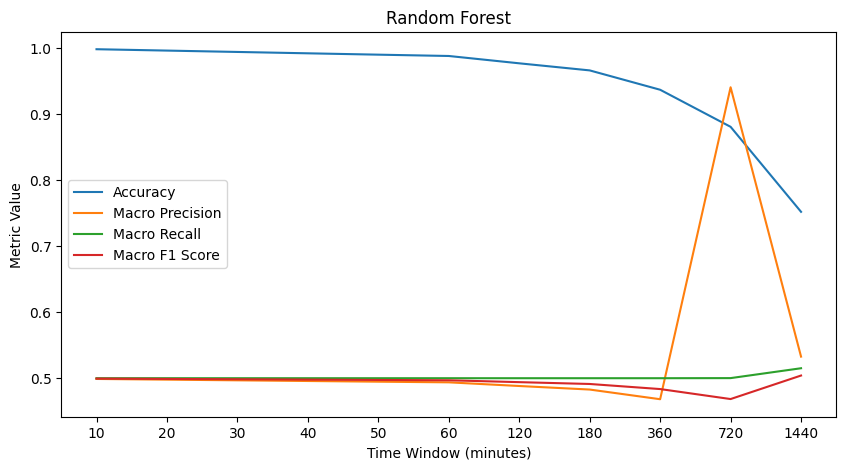

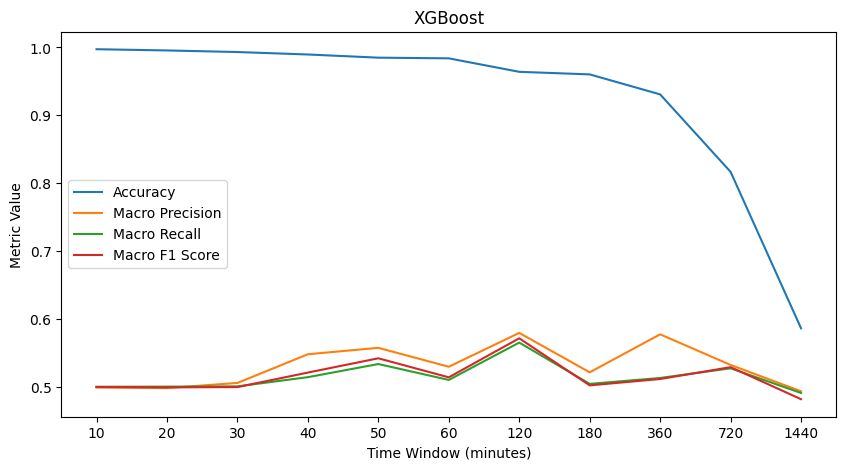

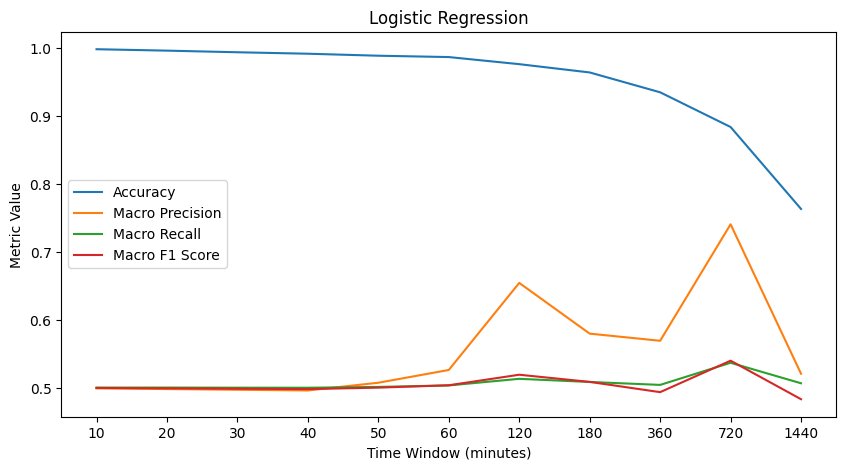

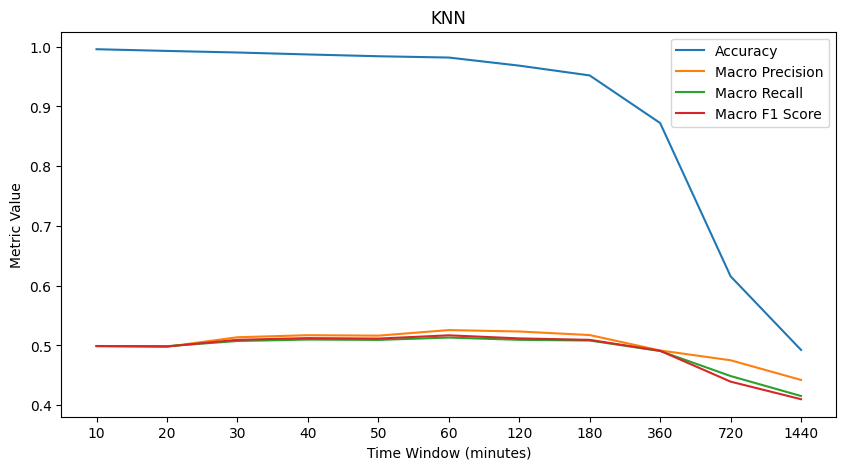

In [190]:
plot_report(rf_crs, "Random Forest")
plot_report(xg_crs, "XGBoost")
plot_report(ln_crs, "Logistic Regression")
plot_report(knn_crs, "KNN")

### Plot report vs method accuracy

In [184]:
def plot_report_vs(rf_rep, xg_rep, ln_rep, knn_rep):
    rf_acc = []
    xg_acc = []
    ln_acc = []
    knn_acc = []
    for i in range(len(rf_rep)):
        rf_acc.append(rf_rep[i]['accuracy'])
        xg_acc.append(xg_rep[i]['accuracy'])
        ln_acc.append(ln_rep[i]['accuracy'])
        knn_acc.append(knn_rep[i]['accuracy'])

    plt.figure(figsize=(10, 5))
    plt.plot(rf_acc, label='Random Forest')
    plt.plot(xg_acc, label='XGBoost')
    plt.plot(ln_acc, label='Linear Regression')
    plt.plot(knn_acc, label='K-Nearest Neighbours')
    plt.title('Accuracy')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Metric Value')
    plt.xticks(range(11), twindows)
    plt.legend()
    plt.show()

Call function

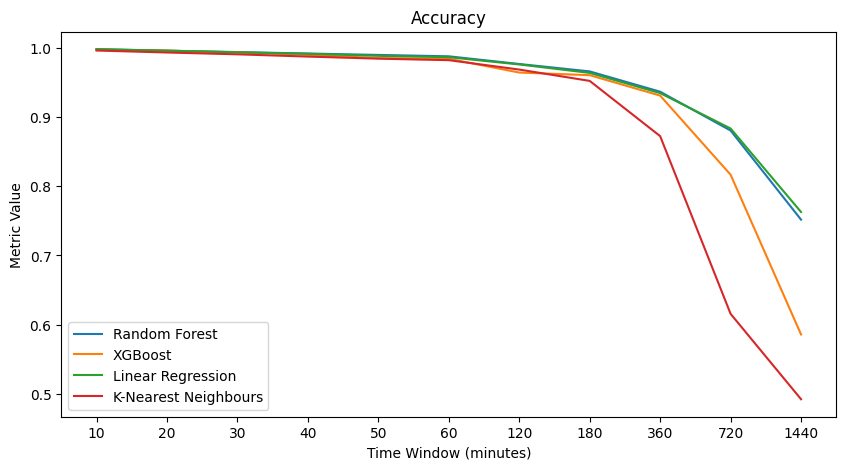

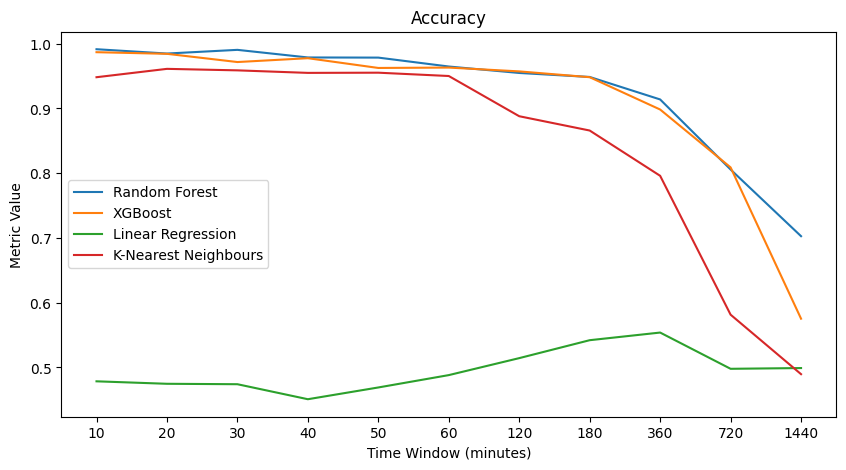

In [185]:
plot_report_vs(rf_crs, xg_crs, ln_crs, knn_crs)
plot_report_vs(rf_crs_smote, xg_crs_smote, ln_crs_smote, knn_crs_smote)

### Vs method Precision 

In [186]:
def plot_report_vs(rf_rep, xg_rep, ln_rep, knn_rep):
    rf_acc = []
    xg_acc = []
    ln_acc = []
    knn_acc = []
    for i in range(len(rf_rep)):
        rf_acc.append(rf_rep[i]['macro avg']['precision'])
        xg_acc.append(xg_rep[i]['macro avg']['precision'])
        ln_acc.append(ln_rep[i]['macro avg']['precision'])
        knn_acc.append(knn_rep[i]['macro avg']['precision'])

    plt.figure(figsize=(10, 5))
    plt.plot(rf_acc, label='Random Forest')
    plt.plot(xg_acc, label='XGBoost')
    plt.plot(ln_acc, label='Linear Regression')
    plt.plot(knn_acc, label='K-Nearest Neighbours')
    plt.title('Macro Precision')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Metric Value')
    plt.xticks(range(11), twindows)
    plt.legend()
    plt.show()

Call function

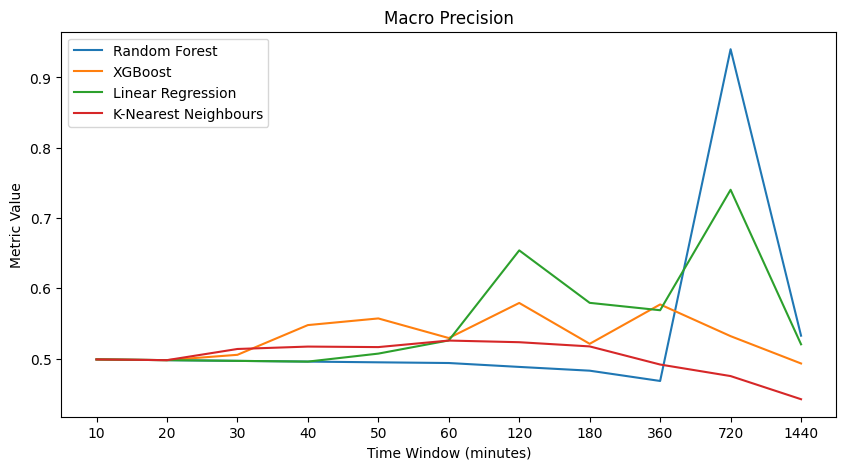

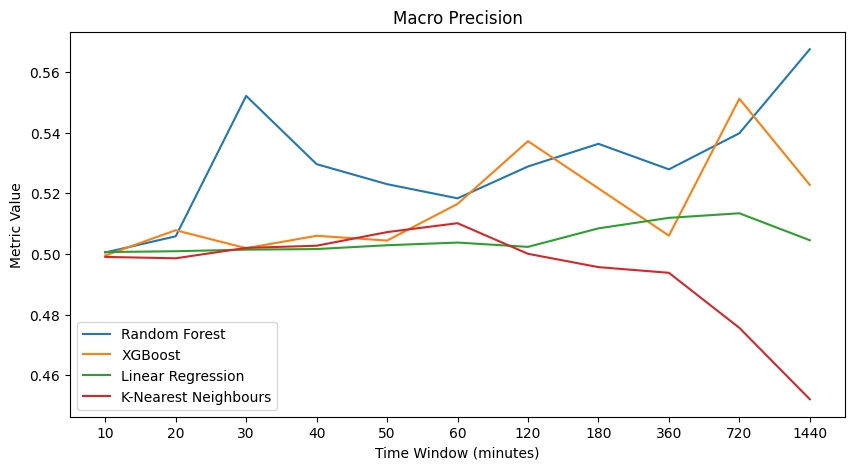

In [187]:
plot_report_vs(rf_crs, xg_crs, ln_crs, knn_crs)
plot_report_vs(rf_crs_smote, xg_crs_smote, ln_crs_smote, knn_crs_smote)

### Vs method Recall

In [188]:
def plot_report_vs_recall(rf_rep, xg_rep, ln_rep, knn_rep):
    rf_acc = []
    xg_acc = []
    ln_acc = []
    knn_acc = []
    for i in range(len(rf_rep)):
        rf_acc.append(rf_rep[i]['macro avg']['recall'])
        xg_acc.append(xg_rep[i]['macro avg']['recall'])
        ln_acc.append(ln_rep[i]['macro avg']['recall'])
        knn_acc.append(knn_rep[i]['macro avg']['recall'])

    plt.figure(figsize=(10, 5))
    plt.plot(rf_acc, label='Random Forest')
    plt.plot(xg_acc, label='XGBoost')
    plt.plot(ln_acc, label='Linear Regression')
    plt.plot(knn_acc, label='K-Nearest Neighbours')
    plt.title('Recall')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Metric Value')
    plt.xticks(range(11), twindows)
    plt.legend()
    plt.show()

Call function

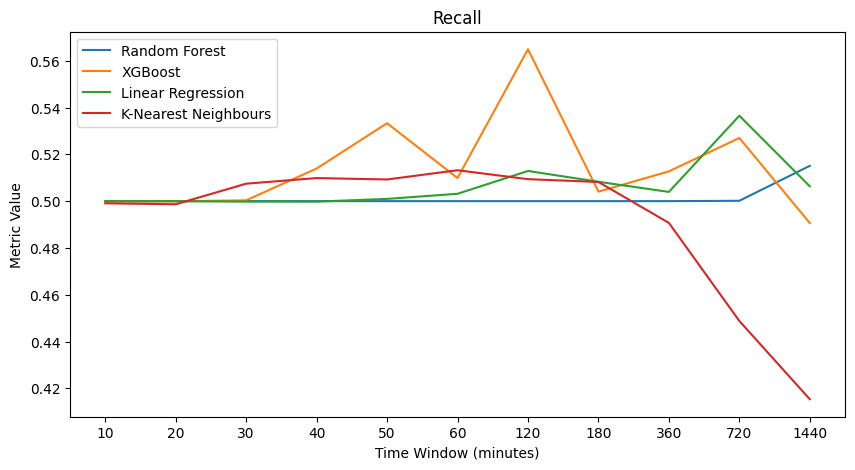

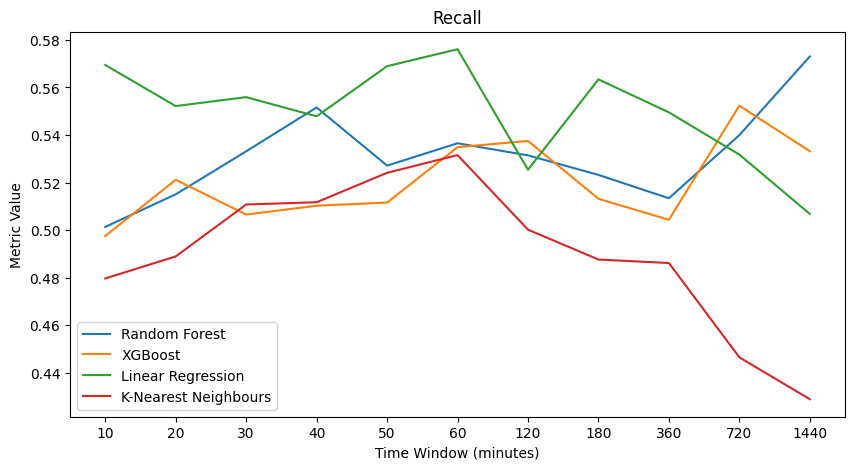

In [189]:
plot_report_vs_recall(rf_crs, xg_crs, ln_crs, knn_crs)
plot_report_vs_recall(rf_crs_smote, xg_crs_smote, ln_crs_smote, knn_crs_smote)

### Vs method F1 Score

In [197]:
def plot_report_vs_f1(rf_rep, xg_rep, ln_rep, knn_rep):
    rf_acc = []
    xg_acc = []
    ln_acc = []
    knn_acc = []
    for i in range(len(rf_rep)):
        rf_acc.append(rf_rep[i]['macro avg']['f1-score'])
        xg_acc.append(xg_rep[i]['macro avg']['f1-score'])
        ln_acc.append(ln_rep[i]['macro avg']['f1-score'])
        knn_acc.append(knn_rep[i]['macro avg']['f1-score'])

    plt.figure(figsize=(10, 5))
    plt.plot(rf_acc, label='Random Forest')
    plt.plot(xg_acc, label='XGBoost')
    plt.plot(ln_acc, label='Linear Regression')
    plt.plot(knn_acc, label='K-Nearest Neighbours')
    plt.title('F1 Score')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Metric Value')
    plt.xticks(range(11), twindows)
    plt.legend()
    plt.show()

Call function

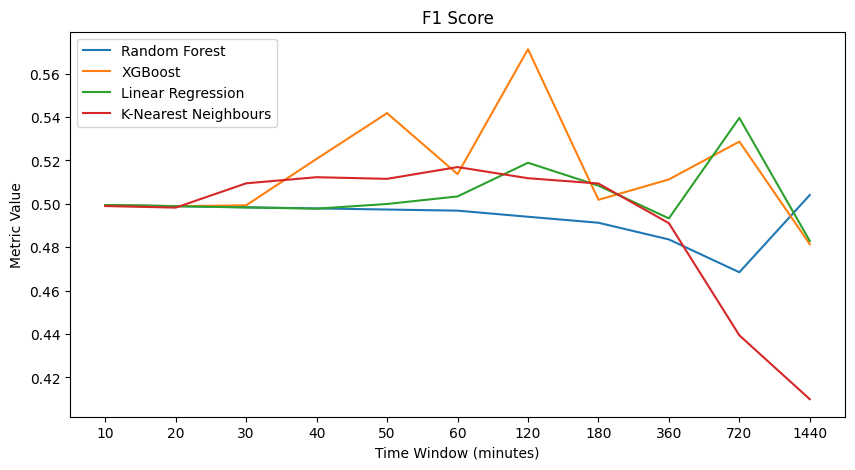

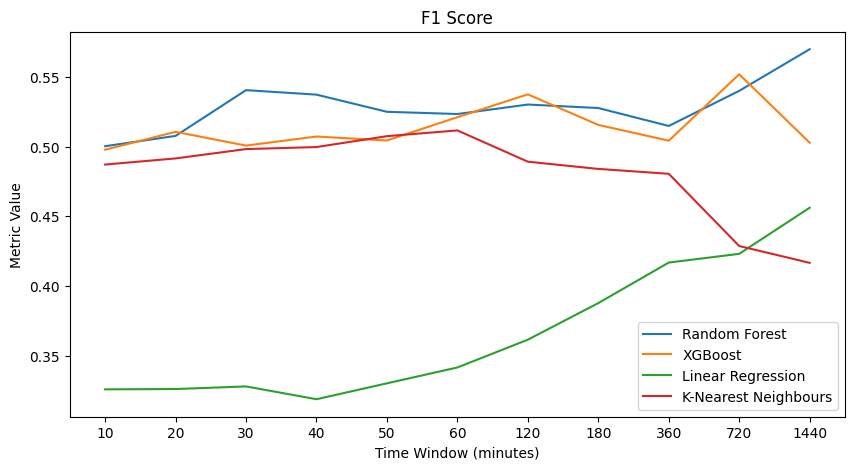

In [198]:
plot_report_vs_f1(rf_crs, xg_crs, ln_crs, knn_crs)
plot_report_vs_f1(rf_crs_smote, xg_crs_smote, ln_crs_smote, knn_crs_smote)